# Coug Data Visualization

In [1]:
# imports
import rosbags_converter as rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seatrac_enums import CST_E
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress

/home/claytonsmith/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# User Variables

ROSBAGS_DIR = "~/postprocessing"
SAVES_DIR = "~/postprocessing/converted_bags"

MISSION_KEYWORDS = ["3.0","4.0","5.5"]
VEHCILE_NAMESPACES = ["/coug1", "/coug2"]
VEHICLE_IDS = [1,2]

VERBOSE=True

In [3]:
# Convert Rosbags
dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS, verbose=True)
if len(dataframes)==0:
    print("converting rosbags")
    typestore = rc.generate_typestore("../../cougars-ros2/src")
    dataframes = rc.convert_rosbags(ROSBAGS_DIR, typestore, 
                                    keywords=MISSION_KEYWORDS,verbose=VERBOSE)
    rc.save_to_csv(dataframes, SAVES_DIR, verbose=VERBOSE)
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS)

Loading /home/claytonsmith/postprocessing/converted_bags/SpanishOaks-March-21-2025/bags/coug2/converted__SO_4.0-2025-03-21-11-10-33
Loading /home/claytonsmith/postprocessing/converted_bags/SpanishOaks-March-21-2025/bags/coug2/converted__SO_3.0-2025-03-21-10-42-27
Loading /home/claytonsmith/postprocessing/converted_bags/Spanish Oaks - Apr 18/bags/coug3_bluey/converted__SO_5.5_multi-2025-04-04-20-54-00
Loading /home/claytonsmith/postprocessing/converted_bags/Spanish Oaks - Apr 18/bags/coug3_bluey/converted__SO_5.5_multi-2025-04-04-20-54-41
Loading /home/claytonsmith/postprocessing/converted_bags/Spanish Oaks - Apr 18/bags/base_station/converted__SO_4.0_multi_base_station
Loading /home/claytonsmith/postprocessing/converted_bags/Spanish Oaks - Apr 18/bags/base_station/converted__SO_multi_3.0
Loading /home/claytonsmith/postprocessing/converted_bags/Spanish Oaks - Apr 18/bags/base_station/converted__SO_5.5_multi
Loading /home/claytonsmith/postprocessing/converted_bags/Spanish Oaks - Apr 18/b

In [4]:
# display topics by rosbag
for path, topics in dataframes.items():
    print(f"{path}:\n\t{list(topics.keys())}")

SpanishOaks-March-21-2025/bags/coug2/converted__SO_4.0-2025-03-21-11-10-33:
	['/coug2/desired_heading', '/coug2/controls/command', '/coug2/controls/debug', '/coug2/fix', '/coug2/dvl/dr_global', '/coug2/dvl/data', '/coug2/dvl/position', '/coug2/odom', '/coug2/leak/data', '/coug2/depth_data', '/coug2/battery/data', '/coug2/dvl/velocity', '/coug2/pressure/data', '/coug2/extended_fix', '/coug2/gps_odom', '/coug2/dvl/dead_reckoning', '/coug2/modem_status', '/coug2/modem_imu', '/coug2/desired_depth', '/coug2/kinematics/command', '/tf', '/coug2/desired_speed']
SpanishOaks-March-21-2025/bags/coug2/converted__SO_3.0-2025-03-21-10-42-27:
	['/coug2/desired_heading', '/coug2/controls/command', '/coug2/controls/debug', '/coug2/fix', '/coug2/dvl/dr_global', '/coug2/odom', '/coug2/leak/data', '/coug2/depth_data', '/coug2/battery/data', '/coug2/dvl/velocity', '/coug2/pressure/data', '/coug2/extended_fix', '/coug2/gps_odom', '/coug2/dvl/dead_reckoning', '/coug2/modem_status', '/coug2/modem_imu', '/coug

In [5]:
# lists dataframes by topic. 
# Assumes all vehicles have different namespaces
# Check previous cell output to confirm this is the case
dfsByMission = {}
for keyword in MISSION_KEYWORDS:
    dfsByTopic = {}
    for path, topic_dfs in dataframes.items(): 
        if keyword in path.parts[-1]:
            dfsByTopic.update(topic_dfs)
    dfsByMission[keyword] = dfsByTopic
    print(f"{keyword}: {list(dfsByTopic.keys())}")

3.0: ['/coug2/desired_heading', '/coug2/controls/command', '/coug2/controls/debug', '/coug2/fix', '/coug2/dvl/dr_global', '/coug2/odom', '/coug2/leak/data', '/coug2/depth_data', '/coug2/battery/data', '/coug2/dvl/velocity', '/coug2/pressure/data', '/coug2/extended_fix', '/coug2/gps_odom', '/coug2/dvl/dead_reckoning', '/coug2/modem_status', '/coug2/modem_imu', '/coug2/desired_depth', '/coug2/kinematics/command', '/tf', '/coug2/desired_speed', '/modem_rec', '/modem_send', '/modem_status', '/modem_cmd_update', '/coug1/extended_fix', '/coug1/dvl/dr_global', '/coug1/modem_rec', '/coug1/controls/command', '/coug1/dvl/dead_reckoning', '/coug1/gps_odom', '/coug1/desired_heading', '/coug1/modem_status', '/coug1/modem_imu', '/coug1/leak/data', '/coug1/dvl/data', '/coug1/safety_status', '/coug1/controls/debug', '/coug1/fix', '/coug1/pressure/data', '/coug1/battery/data', '/coug1/depth_data', '/coug1/dvl/position', '/coug1/kinematics/command', '/coug1/desired_speed', '/coug1/desired_depth', '/tf_s

In [6]:
# Display a dataframe
try:
    print(f"DataFrame example: base station modem update")
    sampleDf = dfsByMission[MISSION_KEYWORDS[0]]["/modem_status"]
    print(sampleDf.iloc[:5,:4])
    print("...")
except:
    print("no data")

DataFrame example: base station modem update
   header.stamp.sec  header.stamp.nanosec  header.frame_id  msg_id
0        1745008829             947000119              NaN      16
1        1745008830              48018862              NaN      16
2        1745008830             148999797              NaN      16
3        1745008830             250083192              NaN      16
4        1745008830             351086649              NaN      16
...


In [7]:
# convert ros timestamps to pandas timestamps
for mission, dfsByTopic in dfsByMission.items():
    print(f"--- {mission} ---")
    for df in dfsByTopic.values():
        if "header.stamp.sec" in df.columns: 
            df["timestamp"] = pd.to_datetime(
                df["header.stamp.sec"] * 1_000_000_000 
                + df["header.stamp.nanosec"], unit='ns'
            )
    try:
        bst_timestamps = dfsByTopic["/modem_status"]["timestamp"]
        bst_dt = (bst_timestamps.max() - bst_timestamps.min()).seconds
        print(f"basestation:\t{bst_dt}s, {bst_timestamps.min()} --- {bst_timestamps.max()}")
    except:
        print("basestation: no data")
    for ns in VEHCILE_NAMESPACES:
        try:
            timestamps = dfsByTopic[ns+'/modem_status']['timestamp']
            dt = (timestamps.max() - timestamps.min()).seconds
            print(f"{ns}:\t{dt}s,\t{timestamps.min()} --- {timestamps.max()}")
        except:
            print(f"{ns}: no data")

--- 3.0 ---
basestation:	210s, 2025-04-18 20:40:29.947000119 --- 2025-04-18 20:44:00.812101176
/coug1:	318s,	2025-04-18 20:40:45.269524261 --- 2025-04-18 20:46:04.004334938
/coug2:	204s,	2025-04-04 22:00:36.351335939 --- 2025-04-04 22:04:00.398104697
--- 4.0 ---
basestation:	257s, 2025-04-18 21:03:51.457720489 --- 2025-04-18 21:08:08.808959982
/coug1:	331s,	2025-04-18 21:04:06.987307521 --- 2025-04-18 21:09:38.893311163
/coug2:	199s,	2025-04-04 22:23:02.615699898 --- 2025-04-04 22:26:22.333278956
--- 5.5 ---
basestation:	112s, 2025-04-18 22:42:43.255680539 --- 2025-04-18 22:44:36.028592480
/coug1:	274s,	2025-04-18 22:42:59.484101776 --- 2025-04-18 22:47:33.937215951
/coug2:	234s,	2025-04-18 22:43:00.784466207 --- 2025-04-18 22:46:55.201137650


In [8]:
# helpful timestamps function
def timewise_gen(
        timestamps,
        dataframes:tuple[pd.DataFrame],\
        accept_range:pd.Timedelta|None=None,
        skip_missing=True,
        repeat=True
):
    idxs = [0]*len(dataframes)
    for timestamp in timestamps:
        rows = []
        last_rows = [None]*len(dataframes)
        for i, df in enumerate(dataframes):
            row = df.iloc[idxs[i]]
            while idxs[i]<len(df)-1 and row["timestamp"] < timestamp:
                idxs[i] += 1
                row = df.iloc[idxs[i]]
            prev_row = df.iloc[max(idxs[i]-1,0)]
            prev_ts = prev_row["timestamp"]
            next_ts = row["timestamp"]
            if timestamp-prev_ts <= next_ts-timestamp:
                row = prev_row
            if accept_range is not None and \
              accept_range < abs(row["timestamp"]-timestamp):
                row = None
            if (not repeat) and (last_rows[i]==row):
                row = None
            else: last_rows[i] = row
            rows.append(row)
        if skip_missing and any(row is None for row in rows): continue
        yield tuple(rows)


--- 3.0 ---


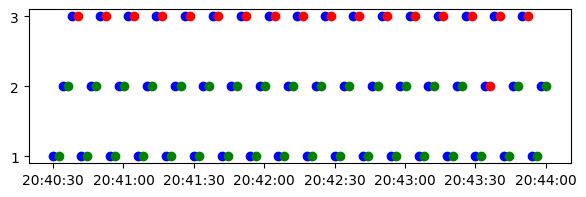

--- 4.0 ---


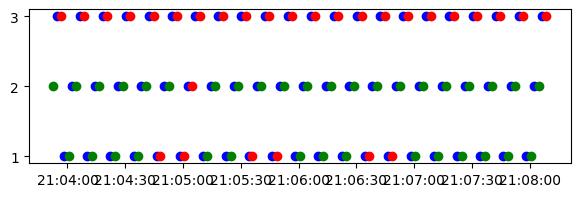

--- 5.5 ---


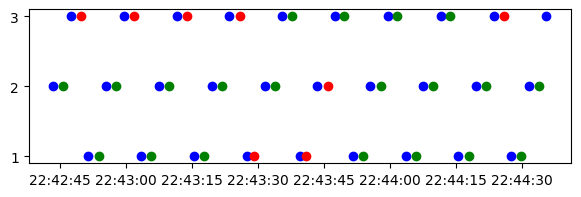

In [9]:
# Base station pings over time
for mission, dfsByTopic in dfsByMission.items():
    try:
        print(f"--- {mission} ---")
        bst_rec = dfsByTopic["/modem_rec"]
        bst_cmd = dfsByTopic["/modem_cmd_update"]
        bst_send = bst_cmd[bst_cmd["command_status_code"]==CST_E.CST_OK]
        bst_err = bst_cmd[bst_cmd["command_status_code"]!=CST_E.CST_OK]

        # bst_send = bst_send[bst_send["target_id"]!=3]
        # bst_rec = bst_rec[bst_rec["src_id"]!=3]
        # bst_err = bst_err[bst_err["target_id"]!=3]

        fig, ax = plt.subplots(figsize=(7, 2))
        ax.plot(bst_send["timestamp"], bst_send["target_id"], 'bo')
        ax.plot(bst_rec["timestamp"], bst_rec["src_id"], 'go')
        ax.plot(bst_err["timestamp"], bst_err["target_id"], 'ro')
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        plt.show()
    except KeyError:
        print("no data")

--- 3.0 ---


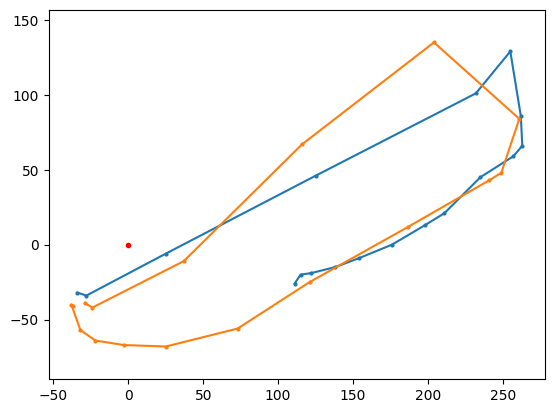

--- 4.0 ---


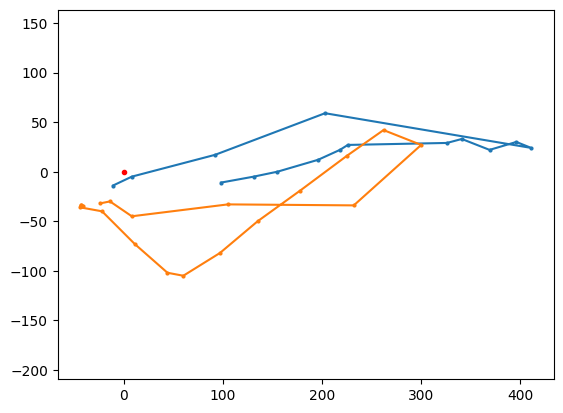

--- 5.5 ---


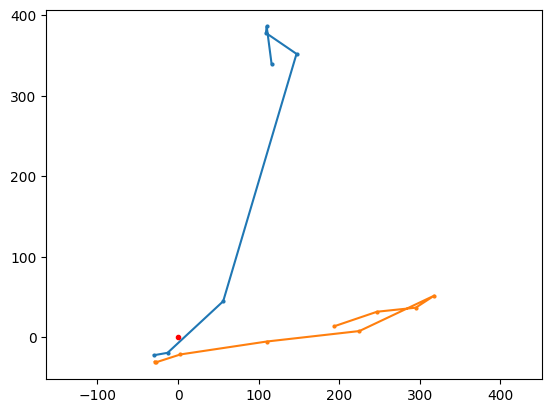

In [10]:
# Modem predicted paths relative to base station
for mission, dfsByTopic in dfsByMission.items():
    try:
        print(f"--- {mission} ---")
        bst_rec = dfsByTopic["/modem_rec"]
        
        for bid in range(15):
            modem_from_bid = bst_rec[bst_rec['src_id']==bid]
            if len(modem_from_bid)>0:
                plt.plot(modem_from_bid['position_easting'],
                        modem_from_bid['position_northing'], 
                        "-o", markersize=2)
        plt.plot([0],[0],'ro',markersize=3)
        plt.axis('equal')
        plt.show()
    except KeyError:
        print("no data")

--- 3.0 ---
/coug1


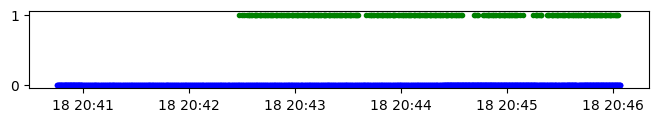

/coug2


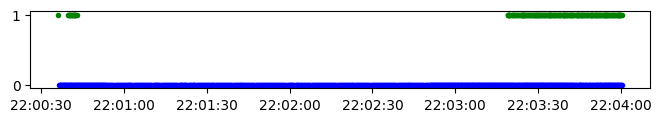

--- 4.0 ---
/coug1


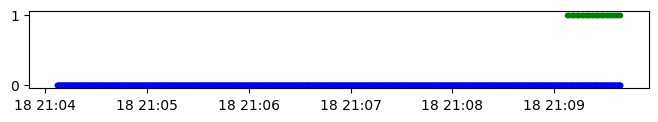

/coug2


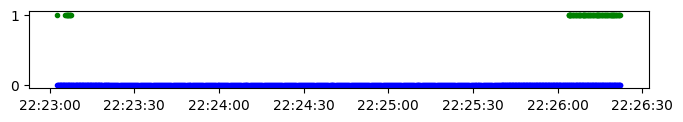

--- 5.5 ---
/coug1


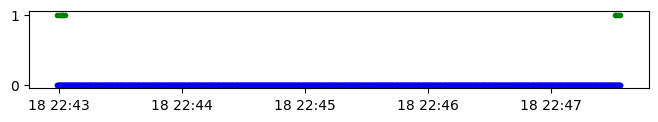

/coug2


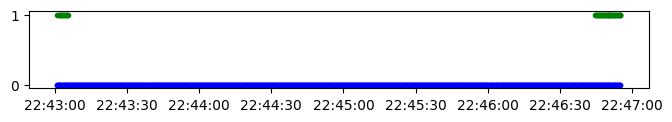

In [11]:
# GPS and DVL timeseries
for mission, dfsByTopic in dfsByMission.items():
    print(f"--- {mission} ---")
    for ns in VEHCILE_NAMESPACES:
        try:
            gps_df = dfsByTopic[ns+"/gps_odom"]
            dvl_df = dfsByTopic[ns+"/dvl/dead_reckoning"]
            gps_ts = gps_df["timestamp"]
            dvl_ts = dvl_df["timestamp"]
            fig, ax = plt.subplots(figsize=(8, 1))
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax.plot(gps_ts, [1]*len(gps_ts), 'go', markersize=3)
            ax.plot(dvl_ts, [0]*len(dvl_ts), 'bo', markersize=3)
            print(ns)
            plt.show()
        except KeyError:
            print(ns+": no data")


In [12]:


# from scipy.spatial.transform import Rotation as R
# from math import sin, cos, pi

# for mission, dfsByTopic in dfsByMission.items():
#     print(f"--- {mission} ---")
#     for ns in VEHCILE_NAMESPACES:
#         try:
#             dvl_df = dfsByTopic[ns+"/dvl/dead_reckoning"]
#             plt.plot(dvl_df["pose.pose.position.x"], dvl_df["pose.pose.position.y"])
#             for i in range(0,len(dvl_df),10):
#                 dvl_row = dvl_df.iloc[i]
#                 x = dvl_row["pose.pose.position.x"]
#                 y = dvl_row["pose.pose.position.y"]
#                 dr_q = [dvl_row['pose.pose.orientation.x'], dvl_row['pose.pose.orientation.y'],
#                 dvl_row['pose.pose.orientation.z'], dvl_row['pose.pose.orientation.w']]
#                 dr_R = R.from_quat(dr_q)
#                 dr_yaw = dr_R.as_euler('zyx', degrees=False)[0]
                
#                 # print(dr_yaw)
#                 # plt.plot(sx, sy, 'o')
#                 plt.plot([x, x+50*cos(dr_yaw)],[y, y+50*sin(dr_yaw)])

#             print(ns)
#             plt.axis('equal')
#             plt.show()
#         except KeyError:
#             print(ns+": no data")

In [13]:

# from scipy.spatial.transform import Rotation as R
# from math import sin, cos, pi

# for mission, dfsByTopic in dfsByMission.items():
#     print(f"--- {mission} ---")
#     for ns in VEHCILE_NAMESPACES:
#         try:
#             dvl_df = dfsByTopic[ns+"/dvl/position"]

#             for i in range(0,len(dvl_df),10):
#                 dvl_row = dvl_df.iloc[i]
#                 x = dvl_row["position.x"]
#                 y = dvl_row["position.y"]
#                 yaw = dvl_row["yaw"]*pi/180

#                 # print(dr_yaw)
#                 plt.plot([x, x+50*sin(yaw)],[y, y+50*cos(yaw)])

#             plt.plot(dvl_df["position.x"], dvl_df["position.y"])
#             plt.plot(dvl_df.iloc[0]['position.x'], dvl_df.iloc[0]['position.y'], 'o')
#             print(ns)
#             plt.axis('equal')
#             plt.show()
#         except KeyError:
#             print(ns+": no data")

In [14]:
# fix imu timestamps

for mission, dfsByTopic in dfsByMission.items():
    for ns in VEHCILE_NAMESPACES:
        try:
            modem_status = dfsByTopic[ns+"/modem_status"]
            modem_imu = dfsByTopic[ns+"/modem_imu"]
            modem_imu["timestamp"] = modem_status["timestamp"]
        except KeyError:
            pass

--- 3.0 ---
--- 4.0 ---
/coug1


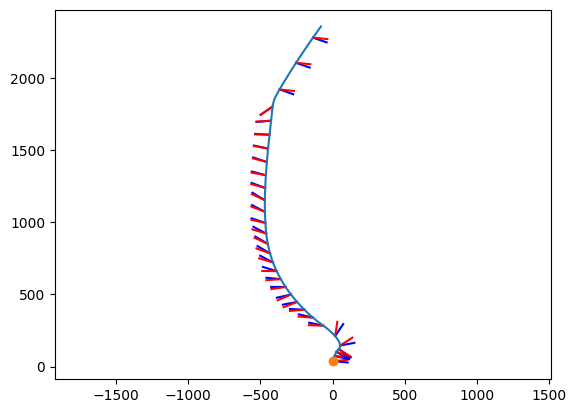

--- 5.5 ---
/coug1


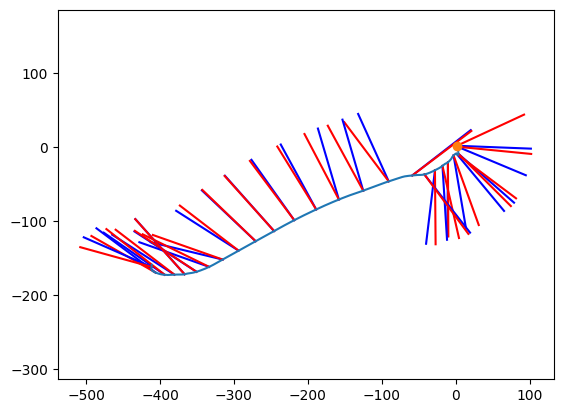

/coug2


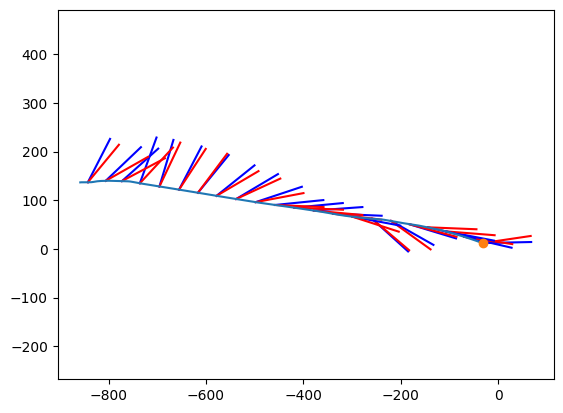

In [ ]:

from scipy.spatial.transform import Rotation as R
from math import sin, cos, pi

for mission, dfsByTopic in dfsByMission.items():
    print(f"--- {mission} ---")
    for ns in VEHCILE_NAMESPACES:
        try:
            dvl_df = dfsByTopic[ns+"/dvl/position"]
            imu_df = dfsByTopic[ns+"/modem_imu"]
            

            x_dist = dvl_df["position.x"].max() - dvl_df["position.x"].min()
            y_dist = dvl_df["position.y"].max() - dvl_df["position.y"].min()
            dist = max(x_dist, y_dist)
            # if x_dist < 200 and y_dist < 200: continue

            imu_idx = 0

            for i in range(0,len(dvl_df),len(dvl_df)//30):
                dvl_row = dvl_df.iloc[i]

                imu_row = imu_df.iloc[imu_idx]
                while (imu_idx < len(imu_df)-1) and \
                (imu_row["timestamp"] < dvl_row["timestamp"]):
                    imu_idx += 1
                    imu_row = imu_df.iloc[imu_idx]

                x = dvl_row["position.x"]
                y = dvl_row["position.y"]
                yaw = dvl_row["yaw"]
                pitch = dvl_row["pitch"]
                roll = dvl_row["roll"]

                imu_R = R.from_quat([
                    imu_row["orientation.x"],
                    imu_row["orientation.y"],
                    imu_row["orientation.z"],
                    imu_row["orientation.w"]
                ])
                imu_yaw = imu_R.inv().as_euler('zyx', degrees=False)[0]

                dvl_R = R.from_euler('xyz', [roll, pitch, yaw], degrees=True)
                # true_yaw = dvl_R.inv().as_euler('zyx',degrees=False)[0]
                true_yaw = dvl_R.inv().as_euler('zyx',degrees=False)[0]+pi/2

                d=0.1*dist
                plt.plot([x, x+d*sin(true_yaw)],[y, y+d*cos(true_yaw)], 'b-')
                # plt.plot([x, x+50*cos(yaw)],[y, y+50*sin(yaw)])
                plt.plot([x, x+d*cos(imu_yaw)],[y, y+d*sin(imu_yaw)], 'r-')

            plt.plot(dvl_df["position.x"], dvl_df["position.y"])
            plt.plot(dvl_df.iloc[0]['position.x'], dvl_df.iloc[0]['position.y'], 'o')
            print(ns)
            plt.axis('equal')
            plt.show()
        except KeyError:
            print(ns+": no data")

--- 3.0 ---
/coug1


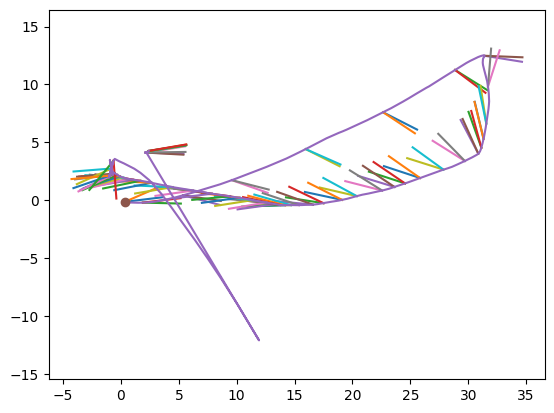

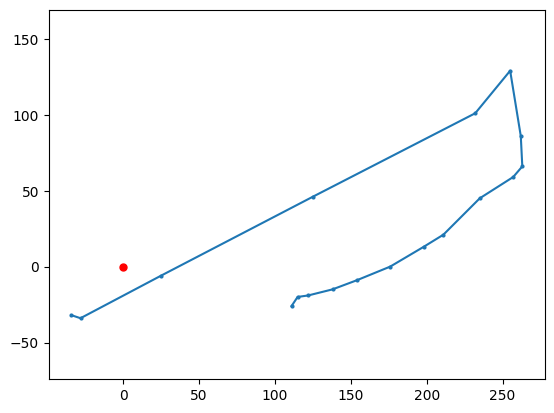

/coug2


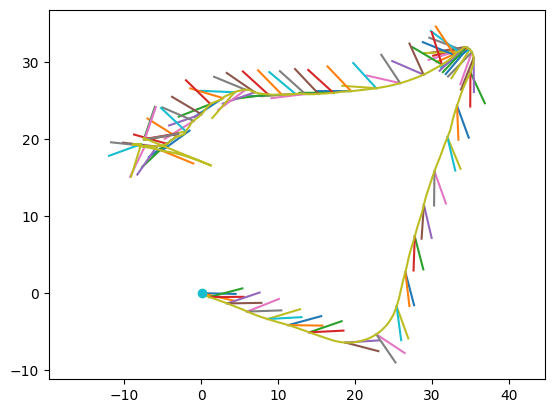

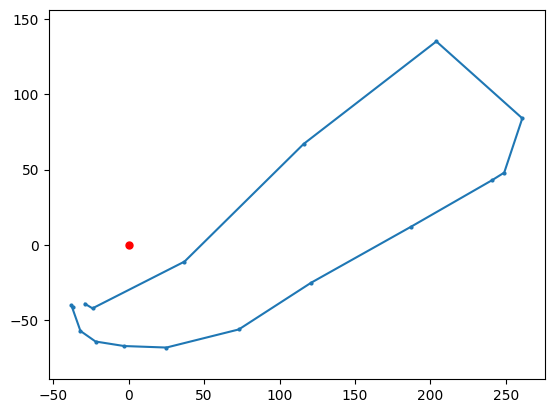

--- 4.0 ---
/coug1


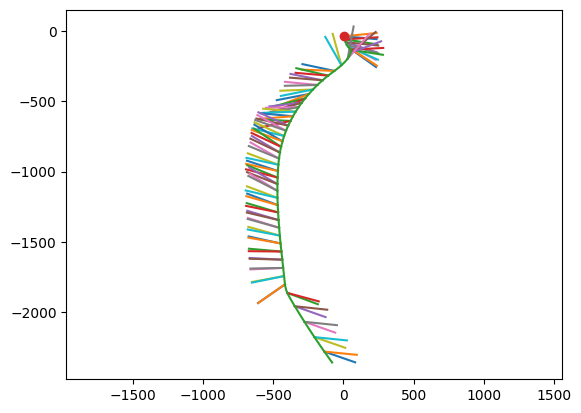

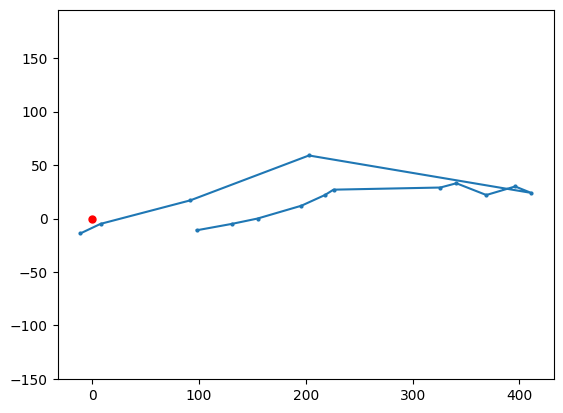

/coug2


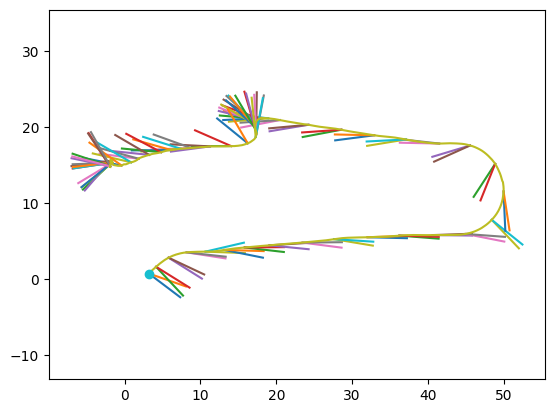

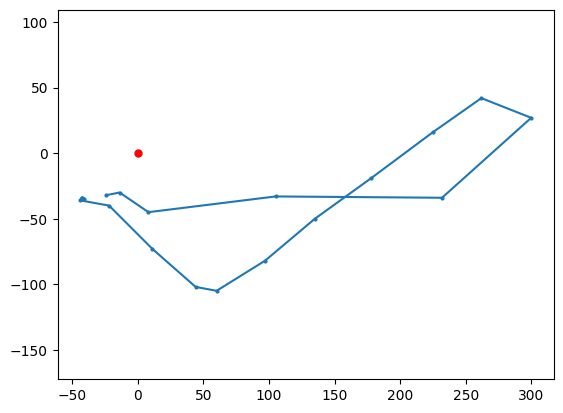

--- 5.5 ---
/coug1


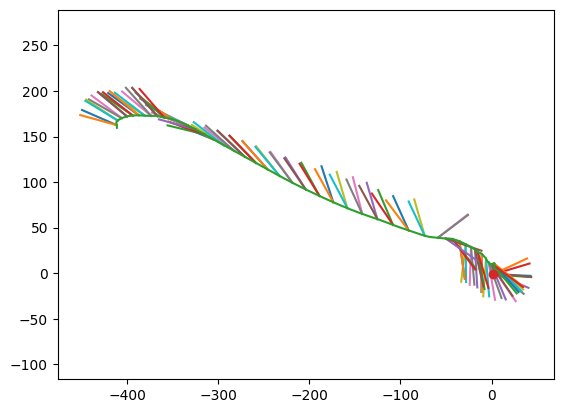

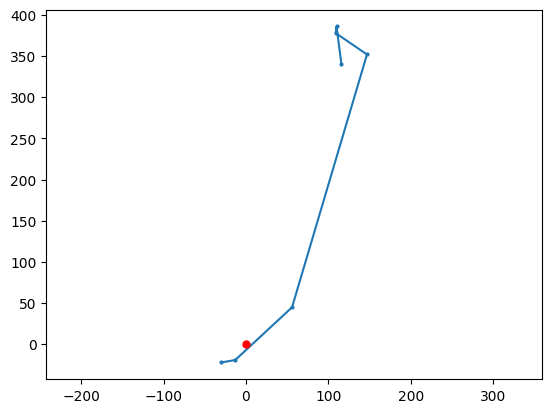

/coug2


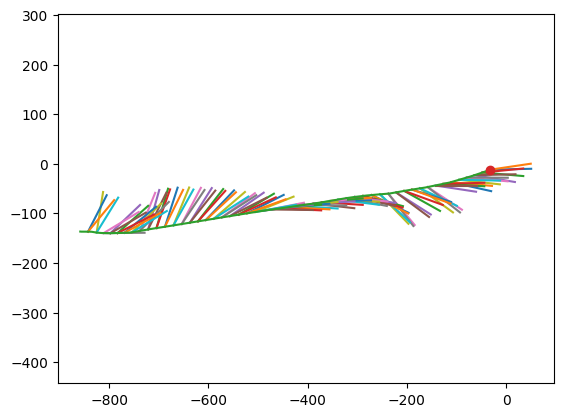

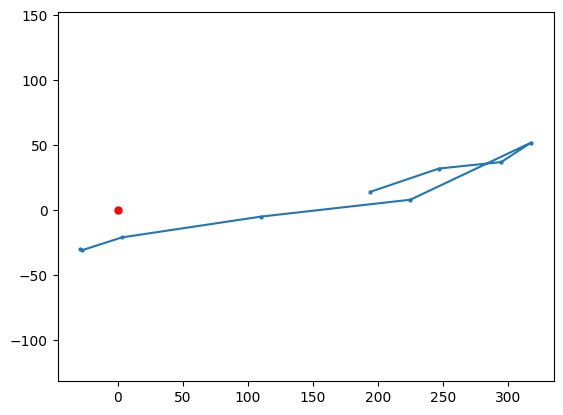

In [ ]:

from scipy.spatial.transform import Rotation as R
from math import sin, cos, pi

for mission, dfsByTopic in dfsByMission.items():
    print(f"--- {mission} ---")
    for bid, ns in zip(VEHICLE_IDS, VEHCILE_NAMESPACES):
        try:
            dvl_df = dfsByTopic[ns+"/dvl/dead_reckoning"]
            imu_df = dfsByTopic[ns+"/modem_imu"]

            x_dist = dvl_df["pose.pose.position.x"].max() - dvl_df["pose.pose.position.x"].min()
            y_dist = dvl_df["pose.pose.position.y"].max() - dvl_df["pose.pose.position.y"].min()
            dist = max(x_dist, y_dist)
            # if x_dist < 200 and y_dist < 200: continue

            imu_idx = 0
            for i in range(0,len(dvl_df),len(dvl_df)//50):
                dvl_row = dvl_df.iloc[i]

                imu_row = imu_df.iloc[imu_idx]
                while (imu_idx < len(imu_df)-1) and \
                (imu_row["timestamp"] < dvl_row["timestamp"]):
                    imu_idx += 1
                    imu_row = imu_df.iloc[imu_idx]

                x = dvl_row["pose.pose.position.x"]
                y = dvl_row["pose.pose.position.y"]
                dr_q = [dvl_row['pose.pose.orientation.x'], dvl_row['pose.pose.orientation.y'],
                dvl_row['pose.pose.orientation.z'], dvl_row['pose.pose.orientation.w']]
                dr_R = R.from_quat(dr_q)
                dr_yaw = dr_R.inv().as_euler('zyx', degrees=False)[0]
                
                imu_R = R.from_quat([
                    imu_row["orientation.x"],
                    imu_row["orientation.y"],
                    imu_row["orientation.z"],
                    imu_row["orientation.w"]
                ])
                imu_yaw = imu_R.inv().as_euler('zyx', degrees=False)[0]

                plt.plot([x, x+0.1*dist*cos(dr_yaw)],[y, y+0.1*dist*sin(dr_yaw)])
                # plt.plot([x, x+0.1*dist*cos(imu_yaw)],[y, y+0.1*dist*sin(imu_yaw)])

            plt.plot(dvl_df["pose.pose.position.x"], dvl_df["pose.pose.position.y"])
            plt.plot(dvl_df.iloc[0]['pose.pose.position.x'], 
                     dvl_df.iloc[0]['pose.pose.position.y'], 'o')
            print(ns)
            plt.axis('equal')
            plt.show()

            bst_rec = dfsByTopic["/modem_rec"]
            modem_from_bid = bst_rec[bst_rec['src_id']==bid]
            if len(modem_from_bid)>0:
                plt.plot(modem_from_bid['position_easting'],
                        modem_from_bid['position_northing'], 
                        "-o", markersize=2)
                plt.plot(0,0,'ro',markersize=5)
                plt.axis('equal')
                plt.show()
        except KeyError:
            print(ns+": no data")

--- 3.0 ---
/coug1


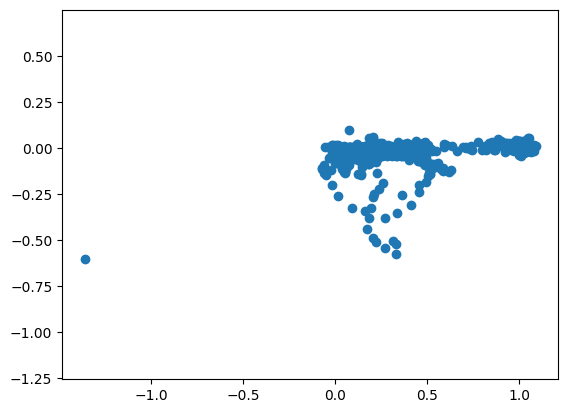

/coug2


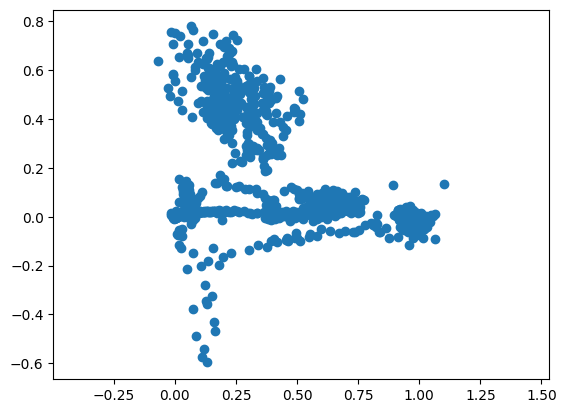

--- 4.0 ---
/coug1: no data
/coug2


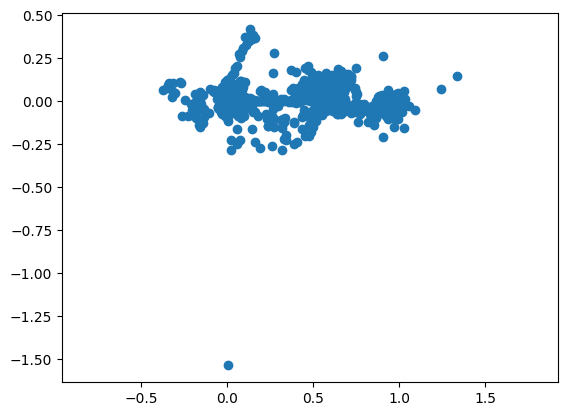

--- 5.5 ---
/coug1: no data
/coug2: no data


In [17]:
# dvl velocity

from scipy.spatial.transform import Rotation as R
from math import sin, cos, pi

for mission, dfsByTopic in dfsByMission.items():
    print(f"--- {mission} ---")
    for ns in VEHCILE_NAMESPACES:
        try:
            dvl_v = dfsByTopic[ns+"/dvl/velocity"]
            imu_df = dfsByTopic[ns+"/modem_imu"]

            x_vel = dvl_v['twist.twist.linear.x']
            y_vel = dvl_v['twist.twist.linear.y']

            plt.plot(x_vel, y_vel, 'o')
            print(ns)
            plt.axis('equal')
            plt.show()
        except KeyError:
            print(ns+": no data")


--- 3.0 ---
/coug1


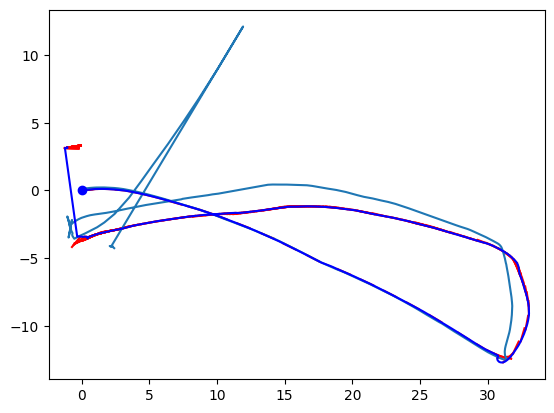

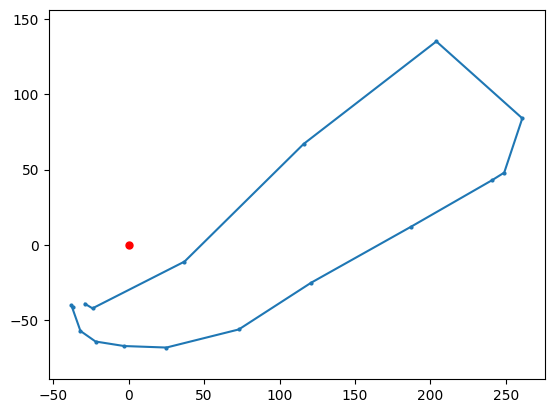

/coug2 problem
--- 4.0 ---
/coug1: no data
'/coug1/dvl/velocity'
/coug2


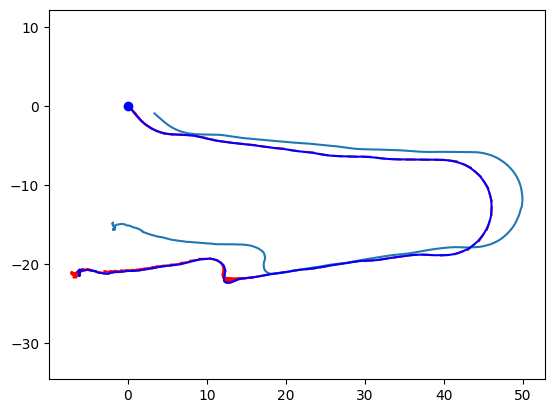

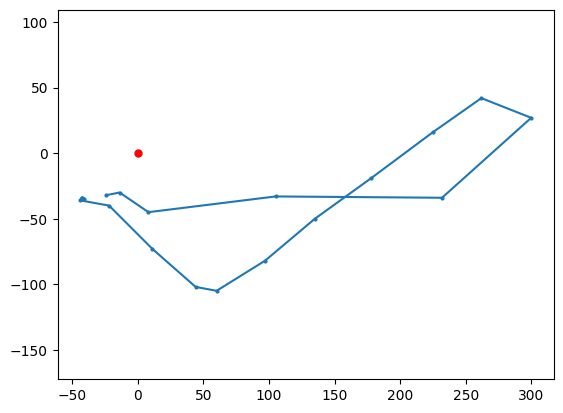

--- 5.5 ---
/coug1: no data
'/coug1/dvl/velocity'
/coug2: no data
'/coug2/dvl/velocity'


In [24]:
# dvl integral approximation

from scipy.spatial.transform import Rotation as R
from math import sin, cos, pi

for mission, dfsByTopic in dfsByMission.items():
    print(f"--- {mission} ---")
    for ns in VEHCILE_NAMESPACES:
        try:
            dvl_v = dfsByTopic[ns+"/dvl/velocity"]
            dvl_p = dfsByTopic[ns+"/dvl/position"]
            # imu_df = dfsByTopic[ns+"/modem_imu"]
            position = np.zeros(3)
            x = []
            y = []
            time_gen = timewise_gen(
                dvl_v["timestamp"], 
                (dvl_v, dvl_p),
                accept_range=pd.Timedelta("1 second"))
            dvl_v_row, dvl_p_row = next(time_gen)
            i = 0
            for next_v_row, next_p_row in time_gen:
                body_v = np.array([
                    dvl_v_row['twist.twist.linear.x'],
                    dvl_v_row['twist.twist.linear.y'],
                    dvl_v_row['twist.twist.linear.z']])
                yaw = dvl_p_row["yaw"]
                pitch = dvl_p_row["pitch"]
                roll = dvl_p_row["roll"]
                dvl_R = R.from_euler('xyz', [roll, pitch, yaw], degrees=True)
                true_yaw = dvl_R.inv().as_euler('zyx',degrees=False)[0]+pi/2
                global_v = np.array(dvl_R.apply(body_v))
                delta_t = (next_v_row["timestamp"]-dvl_v_row["timestamp"]).total_seconds()
                position += delta_t * global_v
                x.append(float(position[0]))
                y.append(float(position[1]))
                dvl_v_row = next_v_row
                dvl_p_row = next_p_row

                if i%10==0:
                    x_ = position[0]
                    y_ = position[1]
                    plt.plot([x_, x_+1*sin(true_yaw)],[y_, y_+1*cos(true_yaw)], 'r-')
                i+=1

            plt.plot(dvl_p["position.x"], dvl_p["position.y"])
            plt.plot(x, y, 'b-')
            plt.plot(0,0,'bo')
            print(ns)
            plt.axis('equal')
            plt.show()

            bst_rec = dfsByTopic["/modem_rec"]
            modem_from_bid = bst_rec[bst_rec['src_id']==bid]
            if len(modem_from_bid)>0:
                plt.plot(modem_from_bid['position_easting'],
                        modem_from_bid['position_northing'], 
                        "-o", markersize=2)
                plt.plot(0,0,'ro',markersize=5)
                plt.axis('equal')
                plt.show()
        except KeyError as e:
            print(ns+": no data")
            print(e)
        except StopIteration:
            print(ns+" problem")